In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import random

from matplotlib.lines import Line2D
from matplotlib import animation
from scipy.integrate import odeint

print('Successfully Imported Packages')

Successfully Imported Packages


In [2]:
def generate_graph(N):
    G = nx.random_geometric_graph(N, 0.15)
    for u in G.nodes:
        G.nodes[u]['state'] = 'S'
    print('Successfully Generated Graph')
    print(f'Nodes: {N}  Edges: {G.number_of_edges()}  Components: {nx.number_connected_components(G)}')
    return G

def load_graph(filename='graph-edgelist.txt'):
    G = nx.read_edgelist(filename)
    print(f'Successfully Loaded Graph from {filename}')
    return G
    
def save_graph(G, filename='graph-edgelist.txt'):
    nx.write_edgelist(G, filename)
    print(f'Successfully Saved Graph to {filename}')

In [3]:
def seirs_simulate(G, beta, sigma, gamma, omega, alpha, e, T_max):
    n = G.number_of_nodes()
    
    SEIRD, X = [], []
    curr = [set() for i in range(5)]
    for u in G.nodes():
        if u in e:
            G.nodes[u]['state'] = 'E'
            curr[1].add(u)
        else:
            G.nodes[u]['state'] = 'S'
            curr[0].add(u)
    
    SEIRD.append([s.copy() for s in curr])
    X.append([len(s) for s in curr])
            
    t = 0
    data = [0, 0]
    while t < T_max and X[t][1] + X[t][2] > 0:
        for u in G.nodes():
            if G.nodes[u]['state'] == 'S':
                inf_nbrs = 0
                for v in G.neighbors(u):
                    if G.nodes[v]['state'] == 'I':
                        inf_nbrs += 1
                        
                if random.random() > pow(1.0 - beta, inf_nbrs):
                    G.nodes[u]['state'] = 'E'
                    curr[0].remove(u)
                    curr[1].add(u)
            
            elif G.nodes[u]['state'] == 'E' and random.random() < sigma:
                G.nodes[u]['state'] = 'I'
                curr[1].remove(u)
                curr[2].add(u)
                data[0] += 1
            
            elif G.nodes[u]['state'] == 'I':
                if random.random() < gamma:
                    G.nodes[u]['state'] = 'R'
                    curr[2].remove(u)
                    curr[3].add(u)
                    data[1] += 1
                    
                elif random.random() < alpha:
                    G.nodes[u]['state'] = 'D'
                    curr[2].remove(u)
                    curr[4].add(u)
            
            elif G.nodes[u]['state'] == 'R' and random.random() < omega:
                G.nodes[u]['state'] = 'S'
                curr[3].remove(u)
                curr[0].add(u)
            
        SEIRD.append([s.copy() for s in curr])
        X.append([len(s) for s in curr])
        t += 1
    
    print(f'Successfully Completed Simulation at T={t}')
    return np.array(X), SEIRD, data

In [4]:
colors = ['tab:blue', 'y', 'r', 'g', 'k']
labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Dead']

In [5]:
legend_data = []
for i in range(5):
    legend_data.append(Line2D([0], [0], marker='o', color='w', label=labels[i], markerfacecolor=colors[i], markersize=10)) 

def network_frame(t, G, layout, SEIRD, ax):
    ax.clear()
    
    nx.draw_networkx_edges(G, layout, alpha=0.5, ax=ax)
    info = []
    for i in range(5):
        nx.draw_networkx_nodes(G, layout, nodelist=SEIRD[t][i], node_size=100, node_color=colors[i], ax=ax)
        info.append(Line2D([0], [0], marker='o', color='w', label=f'{len(SEIRD[t][i])}', 
                           markerfacecolor=colors[i], markersize=10))
    
    ax.set_title(f'T={t}')
    legend = plt.legend(handles=legend_data, bbox_to_anchor=(0, 0, 1, 0), loc='upper left', mode='expand', ncol=5)
    info_legend = plt.legend(handles=info, bbox_to_anchor=(1, 1), loc='upper left', shadow=True)
    ax.add_artist(legend)
    ax.add_artist(info_legend)
    
def animate_network(G, SEIRD, filename='animation-network.gif'):
    fig, ax = plt.subplots(figsize=(10, 10))
    layout = nx.get_node_attributes(G, 'pos')
    
    T = len(SEIRD)
    delay = 500 if T <= 120 else 60000 // T
    
    anim = animation.FuncAnimation(fig, network_frame, frames=T, fargs=(G, layout, SEIRD, ax), 
                                   interval=delay, repeat=True, repeat_delay=2000)
    anim.save(filename, writer='pillow')
    print(f'Successfully saved network animation to {filename}')

In [6]:
def graph_frame(t, X, ax):
    ax.clear()
    
#     ax.stackplot(np.arange(t + 1), np.transpose(X)[:, : t + 1], colors=colors)
    for i in range(5):
        ax.plot(np.arange(t + 1), X[: t + 1, i], lw=2, color=colors[i], label=labels[i])
        ax.plot(t, X[t][i], marker='o', color=colors[i])
    
    for i in range(5):
        plt.fill_between(np.arange(t + 1), X[: t + 1, i], color=colors[i], alpha=0.2)
        
    T, N = len(X) - 1, sum(X[0])
    ax.set_xlim(0, T)
    ax.set_ylim(0, N)
    ax.set_xticks([round(i) for i in np.linspace(0, T, 11)])
    ax.set_yticks([round(i) for i in np.linspace(0, N, 11)])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='darkgray')
    
    ax.set_title(f'SEIRS Epidemic Stochastic Simulation (T={t})')
    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('Nodes')
#     ax.legend(bbox_to_anchor=(1, 1), loc='upper left', shadow=True)
    ax.legend(loc='upper right', shadow=True)

def animate_graph(X, filename='animation-graph.gif'):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    T = len(X)
    delay = 100 if T <= 300 else 30000 // T
    
    anim = animation.FuncAnimation(fig, graph_frame, frames=T, fargs=(X, ax), interval=delay)
    anim.save(filename, writer='pillow')
    print(f'Successfully saved graph animation to {filename}')

In [7]:
def f(y, t, beta, sigma, gamma, omega, alpha):
    ds = -beta * y[0] * y[2] + omega * y[3]
    de = beta * y[0] * y[2] - sigma * y[1]
    di = sigma * y[1] - gamma * y[2] - alpha * y[2]
    dr = gamma * y[2] - omega * y[3]
    dd = alpha * y[2]
    return [ds, de, di, dr, dd]

def graph_ode(X0, t_max, beta, sigma, gamma, omega, alpha, filename='graph-ode.png'):
    fx = odeint(f, X0, np.arange(t_max + 1), args=(beta, sigma, gamma, omega, alpha))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    graph_frame(t_max, fx, ax)
    ax.set_title(f'SEIRS Epidemic Deterministic Model (T={T_MAX})')
    plt.savefig(filename)
    print(f'Successfully saved ODE graph to {filename}')
    plt.show()

In [8]:
def pct_str(val, N):
    return f'{round(100.0 * val / N, 3)}%'

def get_stats(X, data):
    N = sum(X[-1])
    T = len(X) - 1
    
    if X[-1][1] + X[-1][2] > 0:
        print(f'Terminated Simulation at T={T}:')
    else:
        print(f'Simulation Ended at T={T}:')
        
    for i in range(5):
        print(f'{labels[i]}: {X[-1][i]} ({pct_str(X[-1][i], N)})', end='  ')
    
    i_max = 0
    for t in range(1, T + 1):
        if (X[t][2] >= X[i_max][2]):
            i_max = t
            
    avg_ipd = data[0] / T
    avg_rpd = data[1] / T
    avg_dpd = X[-1][4] / T
    
    print(f'\n\nPeak Infection Rate: {X[i_max][2]}/{N} ({pct_str(X[i_max][2], N)}) at T={i_max}')
    print(f'Average Infections/Day: {round(avg_ipd, 3)} ({pct_str(avg_ipd, N)})')
    print(f'Average Recoveries/Day: {round(avg_rpd, 3)} ({pct_str(avg_rpd, N)})')
    print(f'Average Deaths/Day: {round(avg_dpd, 3)} ({pct_str(avg_dpd, N)})')

# Simulation

In [9]:
BETA = 0.8
SIGMA = 0.5
GAMMA = 0.2
OMEGA = 0.2
ALPHA = 0.05

T_MAX = 100
E = [1, 2, 3, 4, 5]

In [10]:
G = generate_graph(100)

Successfully Generated Graph
Nodes: 100  Edges: 299  Components: 1


In [11]:
X, SEIRD, data = seirs_simulate(G, BETA, SIGMA, GAMMA, OMEGA, ALPHA, E, T_MAX)

Successfully Completed Simulation at T=94


Successfully saved graph animation to animation-graph.gif


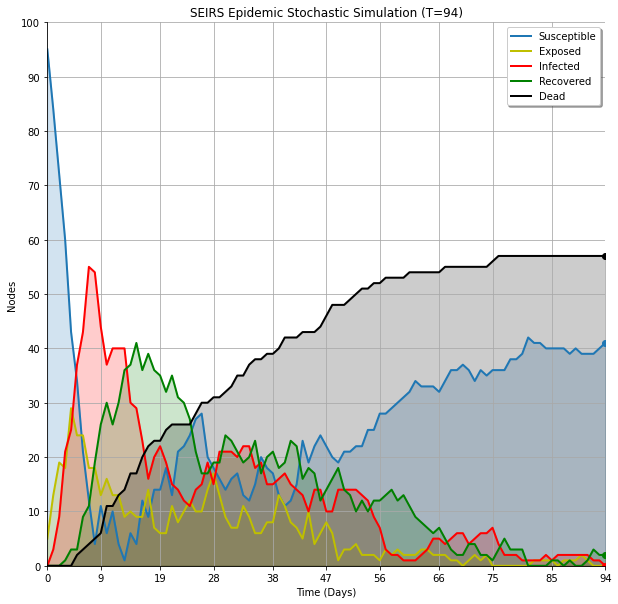

In [12]:
animate_graph(X)

Successfully saved network animation to animation-network.gif


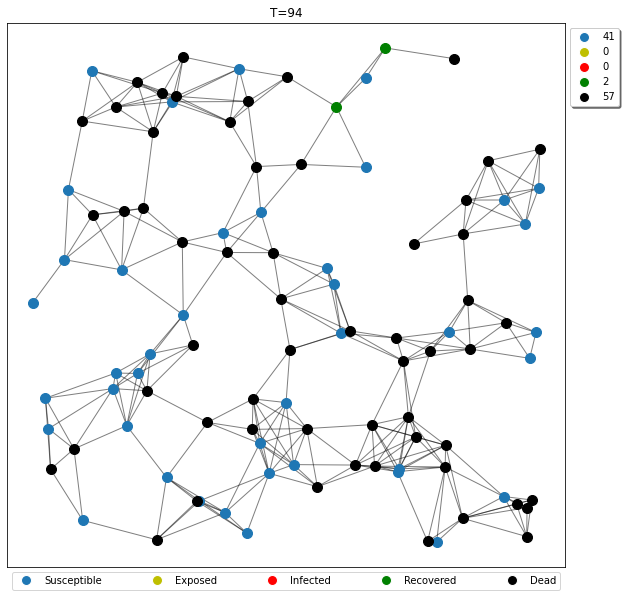

In [13]:
animate_network(G, SEIRD)

Successfully saved ODE graph to graph-ode.png


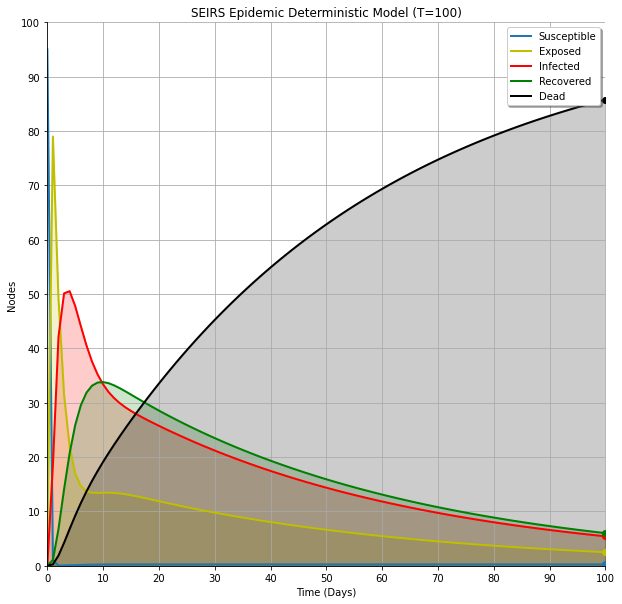

In [14]:
graph_ode(X[0], T_MAX, BETA, SIGMA, GAMMA, OMEGA, ALPHA)

In [15]:
get_stats(X, data)

Simulation Ended at T=94:
Susceptible: 41 (41.0%)  Exposed: 0 (0.0%)  Infected: 0 (0.0%)  Recovered: 2 (2.0%)  Dead: 57 (57.0%)  

Peak Infection Rate: 55/100 (55.0%) at T=7
Average Infections/Day: 3.287 (3.287%)
Average Recoveries/Day: 2.681 (2.681%)
Average Deaths/Day: 0.606 (0.606%)


In [16]:
save_graph(G)

Successfully Saved Graph to graph-edgelist.txt
